# Final Project Submission

Please fill out:
* Student name: Amanda Gaeta
* Student pace: part time
* Scheduled project review date/time: April 7th, 2020 at 4pm CST
* Instructor name: Lindsey Berlin

# Introduction

With Android OS holding 87% of market share in 2019, a VC firm is looking to understand what characteristics are predictive of a positively rated app (4.5+ rating on a 1-5 scale). They want to be able to utilize this information to target possible companies to apply for investment. It can also be applied to weed out those that are not a fit. Given that there are strong signals, these learnings could also be operationally applied to targeting companies to invest in, application questions, and company screenings for more efficient filtering and assessment.

The modeling iterations below have been created using 2019 Google Play Store data with records consisting of apps, their rating, number of installs, reviews, content rating, and more. Throughout the model construction, a focus was placed on scoring high on recall and balanced with the goal of an accuracy score better than a random guess. 

Recall was particularly chosen due to the risk of the model producing False Negatives, which would mean the VC firm would miss the opportunity to bring an app into the world. With recall emphasizing the importance of True Positives, we can focus on identifying apps that would most likely be positively rated. 

Conversely, a precision score was _not_ the focus because it focuses on lessening False Positives, which to the VC firm is investing in something that has less chance being successful, or in this case, an app less likelye to be positively rated. Within the business context, a VC firm is always going to be facing this risk; thus for this purpose recall was confirmed as the priority metric.

# Notebook Summary

#### Models
Note: Models used for analysis italicized

**Phase 1: Data Version 1 and Baseline Testing**
- [Model 1 - Logistic Regression with class balance](#Model_1)
- [Model 2 - Decision Tree with class balance](#Model_2)
- [Model 3 - Random Forest](#Model_3)
- [Model 4 - KNN](#Model_4)
    
**Phase 2: Data Version 2 + 3 and Model Tuning**
- [Model 5 - Decision Tree with Data Version 2 (Less OHE, More Numeric/Ordinal)](#Model_5)
- [Model 6 - Model 5 at Half Depth](#Model_6)
- [Model 7 - GridSearch Decision Tree](#Model_7)
- [Model 8 - GridSearch Random Forest](#Model_8)
- [Model 9 - Decision Tree with Data Version 3 (Additional Ordinal)](#Model_9)
- [Model 10 - Model 9 at Half Depth](#Model_10)
- [_Model 11 - GridSearch2 Decision Tree_](#Model_11)
- [_Model 12 - GridSearch2 Random Forest_](#Model_12)
    
**Phase 3: Feature Importance and Analysis (Baseline, eli5, rfpimp, Drop One Features)**
- [Model 11 Feature Importance](#Model_11_FI)
- [Model 12 Feature Importance](#Model_12_FI)

**Data Analysis**
- [Installs](#Installs)
- [Reviews](#Revs)
- [Size](#Size)
- [Data Analysis learnings](#DAL)

**Conclusion**
- [Recommendations](#REC)
- [Future Work](#FW)



**Results**

The final two models, Model 11 and Model 12, produced either:

1. An accuracy score 1-2% above a random guess and a 50% recall score  (Decision Tree)
OR
2. A 56-58% recall score (and similar cross validation scores for recall, and an accuracy score 2% below a random guess (Random Forest)

Although the model is not in a final versioning to be utilized in day-to-day decisions, the consistency from this version can be generally applied to say that marketing, promotion, and adoption of the app is foundationally important.

Along with the technical aptitude for efficient app development, the VC would want CEOs with strong marketing background, a network with these skills, and/or teams that have this expertise.

### Intro Work

In [1]:
# Imports Data Discovery and Plotting
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Imports Modeling
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score, plot_confusion_matrix, r2_score

# Imports Feature Importance Assists
import operator
from sklearn.base import clone 
import eli5
from eli5.sklearn import PermutationImportance
from rfpimp import permutation_importances

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


#### Functions

In [2]:
def eval_model(estimator, X_train, X_test, y_train, y_test):
    '''
    Evaluation function to show accuracy, recall, mean 3-fold cross-validation 
    for both the train and test set, then shows confusion matrix for the test set
    '''
    # grab predictions
    train_preds = estimator.predict(X_train)
    test_preds = estimator.predict(X_test)
    
    # print scores
    print("Train Scores")
    print("------------")
    print(f"Accuracy: {accuracy_score(y_train, train_preds)}")
    print(f"Recall: {recall_score(y_train, train_preds)}")
    print(f"F1 Score: {f1_score(y_train, train_preds)}")
    print("----" * 5)
    print("Test Scores")
    print("-----------")
    print(f"Accuracy: {accuracy_score(y_test, test_preds)}")
    print(f"Recall: {recall_score(y_test, test_preds)}")
    print(f"Recall Mean Cross Val 3-Fold: {np.mean(cross_val_score(estimator,  X_train, y_train, cv=3, scoring='recall'))}")
    print(f"F1 Score: {f1_score(y_test, test_preds)}")

    # plot test confusion matrix
    plot_confusion_matrix(estimator, X_test, y_test, values_format='')
    plt.show()

In [3]:
# source: https://towardsdatascience.com/explaining-feature-importance-by-example-of-a-random-forest-d9166011959e
from sklearn.base import clone 

def drop_col_feat_imp(model, X_train, y_train, random_state = 42):
    
    # clone the model to have the exact same specification as the one initially trained
    model_clone = clone(model)
    # set random_state for comparability
    model_clone.random_state = random_state
    # training and scoring the benchmark model
    model_clone.fit(X_train, y_train)
    benchmark_score = model_clone.score(X_train, y_train)
    # list for storing feature importances
    importances = []
    
    # iterating over all columns and storing feature importance (difference between benchmark and new model)
    for col in X_train.columns:
        model_clone = clone(model)
        model_clone.random_state = random_state
        model_clone.fit(X_train.drop(col, axis = 1), y_train)
        drop_col_score = model_clone.score(X_train.drop(col, axis = 1), y_train)
        importances.append(benchmark_score - drop_col_score)
    
    importances_df = pd.DataFrame(X_train.columns, importances)
    return importances_df

In [4]:
# source: https://towardsdatascience.com/explaining-feature-importance-by-example-of-a-random-forest-d9166011959e
def r2(rf, X_train, y_train):
    return r2_score(y_train, rf.predict(X_train))

#### Data Import

In [5]:
# Import data
data = pd.read_csv('data/googleplaystore.csv')
data.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [6]:
# create data copy for manipulation
df = data.copy()

In [7]:
# Overview 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
App               10841 non-null object
Category          10841 non-null object
Rating            9367 non-null float64
Reviews           10841 non-null object
Size              10841 non-null object
Installs          10841 non-null object
Type              10840 non-null object
Price             10841 non-null object
Content Rating    10840 non-null object
Genres            10841 non-null object
Last Updated      10841 non-null object
Current Ver       10833 non-null object
Android Ver       10838 non-null object
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


#### Intial Data Cleansing and Review

In [8]:
# Rating is target so drop nulls
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9360 entries, 0 to 10840
Data columns (total 13 columns):
App               9360 non-null object
Category          9360 non-null object
Rating            9360 non-null float64
Reviews           9360 non-null object
Size              9360 non-null object
Installs          9360 non-null object
Type              9360 non-null object
Price             9360 non-null object
Content Rating    9360 non-null object
Genres            9360 non-null object
Last Updated      9360 non-null object
Current Ver       9360 non-null object
Android Ver       9360 non-null object
dtypes: float64(1), object(12)
memory usage: 1023.8+ KB


In [9]:
# Preview Rating values
df['Rating']

0        4.1
1        3.9
2        4.7
3        4.5
4        4.3
        ... 
10834    4.0
10836    4.5
10837    5.0
10839    4.5
10840    4.5
Name: Rating, Length: 9360, dtype: float64

In [10]:
# What % of Ratings are >= 4.5
# 4.5 out of 5 is high rating on Google Play Store
len(df[df['Rating'] >= 4.5])/len(df)

0.3155982905982906

In [11]:
# Create target Positive Rating
df['Pos Rating'] = 0

for row in df['Rating'].index:
    if df['Rating'][row] >= 4.5:
        df['Pos Rating'][row] = 1

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [12]:
# Check work, target created
df['Pos Rating'].value_counts(normalize=True)

0    0.684402
1    0.315598
Name: Pos Rating, dtype: float64

In [13]:
# Type versus Price - view Type distribution
df['Type'].value_counts(normalize=True)

Free    0.93109
Paid    0.06891
Name: Type, dtype: float64

In [14]:
# Initial df cleans and conversions

# Convert to Reviews to numeric, integer
df['Reviews'] = df['Reviews'].astype(int)

# Drop Price column, use Type - 93% are Free or 0 in Price.
df = df.drop(columns='Price', axis=1)

# Drop Rating, duplicative of Pos Rating and is target
df = df.drop(columns='Rating', axis=1)

In [15]:
# Preview new df
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9360 entries, 0 to 10840
Data columns (total 12 columns):
App               9360 non-null object
Category          9360 non-null object
Reviews           9360 non-null int64
Size              9360 non-null object
Installs          9360 non-null object
Type              9360 non-null object
Content Rating    9360 non-null object
Genres            9360 non-null object
Last Updated      9360 non-null object
Current Ver       9360 non-null object
Android Ver       9360 non-null object
Pos Rating        9360 non-null int64
dtypes: int64(2), object(10)
memory usage: 1.2+ MB


In [16]:
# Many are objects - describe
df[[c for c in df.columns if df[c].dtype == 'object']].describe()

# App - drop, equivalent of ID
# Categorry - 33 uniques, OHE
# Size - 413 unique values, most common is Varies with device/in M and k
# will need to convert to same unites
# Installs - can keep as categories and OHE or try numeric
# Content Rating - categorical, but could be ordinal
# Genres - categorical, can OHE; see if there is an opportunity to bucket smaller genres into
# larger ones
# Last Updated - leave out as do not have specific stats for age feature
# Current Version and Android Version are not controllable features

,App,Category,Size,Installs,Type,Content Rating,Genres,Last Updated,Current Ver,Android Ver
count,9360,9360,9360,9360,9360,9360,9360,9360,9360,9360
unique,8190,33,413,19,2,6,115,1299,2638,31
top,ROBLOX,FAMILY,Varies with device,"1,000,000+",Free,Everyone,Tools,"August 3, 2018",Varies with device,4.1 and up
freq,9,1746,1637,1576,8715,7414,732,319,1415,2059


In [17]:
# Define X and y 
X = df.drop(columns=['Pos Rating', 'App', 'Last Updated', 'Current Ver', 'Android Ver'])
y = df['Pos Rating']

In [18]:
# Review X columns for treatment assignment
X.columns

Index(['Category', 'Reviews', 'Size', 'Installs', 'Type', 'Content Rating',
       'Genres'],
      dtype='object')

In [19]:
# Separate for different treatments (scaling and OHE)

num_cols = ['Reviews']

ohe_cols = ['Category', 'Size', 'Installs', 'Type', 'Content Rating', 'Genres']

#### Numeric Treatment - Scale

In [20]:
# Copy df for manipulation
scaled_features = df.copy()

In [21]:
# Scale num_col features
features = scaled_features[num_cols]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)

# Put into DF for concatenation
scaled_features[num_cols] = features
scaled = scaled_features[['Reviews']]

# Check work
scaled.head()

,Reviews
0,-0.163511
1,-0.163254
2,-0.135735
3,-0.094991
4,-0.163254


#### Categorical Treatment (OHE)

In [22]:
# Copy df for manipulation
ohe_features = df.copy()

In [23]:
# Filter down to just ohe_cols
ohe_features = ohe_features[ohe_cols]

# OHE/Get Dummies
ohe_features = pd.get_dummies(ohe_features)

# Preview, check work
ohe_features.head()

,Category_ART_AND_DESIGN,Category_AUTO_AND_VEHICLES,Category_BEAUTY,Category_BOOKS_AND_REFERENCE,Category_BUSINESS,Category_COMICS,Category_COMMUNICATION,Category_DATING,Category_EDUCATION,Category_ENTERTAINMENT,...,Genres_Tools,Genres_Tools;Education,Genres_Travel & Local,Genres_Travel & Local;Action & Adventure,Genres_Trivia,Genres_Video Players & Editors,Genres_Video Players & Editors;Creativity,Genres_Video Players & Editors;Music & Video,Genres_Weather,Genres_Word
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
ohe_features = pd.get_dummies(ohe_features)

#### Combine - Data Version 1 - Many OHE, First Shitty Model

In [25]:
# Combine scaled numerical, OHE categoricals, and target into one df
preprocessed = pd.concat([scaled, ohe_features, y], axis=1)

In [26]:
# Review available columns, check work
preprocessed.columns

Index(['Reviews', 'Category_ART_AND_DESIGN', 'Category_AUTO_AND_VEHICLES',
       'Category_BEAUTY', 'Category_BOOKS_AND_REFERENCE', 'Category_BUSINESS',
       'Category_COMICS', 'Category_COMMUNICATION', 'Category_DATING',
       'Category_EDUCATION',
       ...
       'Genres_Tools;Education', 'Genres_Travel & Local',
       'Genres_Travel & Local;Action & Adventure', 'Genres_Trivia',
       'Genres_Video Players & Editors',
       'Genres_Video Players & Editors;Creativity',
       'Genres_Video Players & Editors;Music & Video', 'Genres_Weather',
       'Genres_Word', 'Pos Rating'],
      dtype='object', length=590)

### First Shitty Model and Estimator Exploration

In [27]:
# X and y split of preprocessed 
X = preprocessed.drop(columns=['Pos Rating'], axis=1)
y = preprocessed['Pos Rating']

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

#### Model 1 - LogReg with Balanced Class Weight <a id="Model_1"></a>

Class weight = 'balanced' to account for 68/32 split of Target

In [29]:
# X and y split of preprocessed 
X = preprocessed.drop(columns=['Pos Rating'], axis=1)
y = preprocessed['Pos Rating']

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [31]:
def eval_model(estimator, X_train, X_test, y_train, y_test):
    '''
    Evaluation function to show accuracy, recall, mean 3-fold cross-validation 
    for both the train and test set, then shows confusion matrix for the test set
    '''
    # grab predictions
    train_preds = estimator.predict(X_train)
    test_preds = estimator.predict(X_test)
    
    # print scores
    print("Train Scores")
    print("------------")
    print(f"Accuracy: {accuracy_score(y_train, train_preds)}")
    print(f"Recall: {recall_score(y_train, train_preds)}")
    print(f"F1 Score: {f1_score(y_train, train_preds)}")
    print("----" * 5)
    print("Test Scores")
    print("-----------")
    print(f"Accuracy: {accuracy_score(y_test, test_preds)}")
    print(f"Recall: {recall_score(y_test, test_preds)}")
    print(f"Recall Mean Cross Val 3-Fold: {np.mean(cross_val_score(estimator,  X_train, y_train, cv=3, scoring='recall'))}")
    print(f"F1 Score: {f1_score(y_test, test_preds)}")

    # plot test confusion matrix
    plot_confusion_matrix(estimator, X_test, y_test, values_format='')
    plt.show()

In [32]:
# Instantiate; adding class weight balanced since 70/30 split of target
logreg = LogisticRegression(class_weight='balanced')

# Fit
logreg.fit(X_train, y_train)

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [33]:
# X and y split of preprocessed 
X = preprocessed.drop(columns=['Pos Rating'], axis=1)
y = preprocessed['Pos Rating']

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

Train Scores
------------
Accuracy: 0.6777777777777778
Recall: 0.644
F1 Score: 0.5616279069767441
--------------------
Test Scores
-----------
Accuracy: 0.6376068376068376
Recall: 0.5880681818181818


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Recall Mean Cross Val 3-Fold: 0.5755555555555556
F1 Score: 0.4940334128878281


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


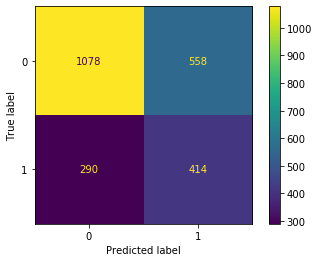

In [35]:
eval_model(logreg, X_train, X_test, y_train, y_test)

# Overfit
# Accuracy worse than random guess (-.05)
# Lower F1 score than recall means precision < recall

#### Model 2 - Decision Tree <a id="Model_2"></a>

Class weight = 'balanced' to account for 68/32 split of Target

In [36]:
# Instantiate
dt = DecisionTreeClassifier(class_weight='balanced')

# Fit
dt.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

Train Scores
------------
Accuracy: 0.9998575498575498
Recall: 1.0
F1 Score: 0.9997778271495222
--------------------
Test Scores
-----------
Accuracy: 0.7243589743589743
Recall: 0.5696022727272727
Recall Mean Cross Val 3-Fold: 0.5631111111111111
F1 Score: 0.5542501727712509


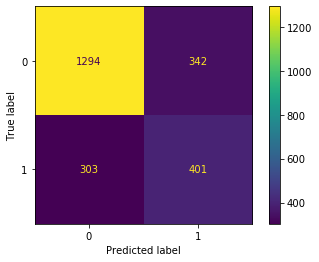

In [37]:
eval_model(dt, X_train, X_test, y_train, y_test)

# Overfit
# Better accuracy than balance logreg
# Similar recall to balanced logreg
# Higher f1 which also means higher precision

#### Model 3 - KNN <a id="Model_3"></a>

In [38]:
# Instantiate
knn = KNeighborsClassifier()

# Fit
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

Train Scores
------------
Accuracy: 0.8032763532763533
Recall: 0.5631111111111111
F1 Score: 0.6472541507024266
--------------------
Test Scores
-----------
Accuracy: 0.7175213675213675
Recall: 0.3806818181818182
Recall Mean Cross Val 3-Fold: 0.3831111111111111
F1 Score: 0.4477861319966583


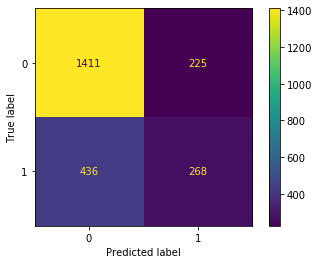

In [39]:
eval_model(knn, X_train, X_test, y_train, y_test)

# Overfit
# Similar accuracy to logreg and decision tree
# Recall and F1 suffers. Stick with decision tree since going for recall

#### Model 4 - Random Forest <a id="Model_4"></a>

In [40]:
# Instantiate
rf = RandomForestClassifier(class_weight='balanced')

# Fit
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Train Scores
------------
Accuracy: 0.9998575498575498
Recall: 0.9995555555555555
F1 Score: 0.9997777283840853
--------------------
Test Scores
-----------
Accuracy: 0.7611111111111111
Recall: 0.44886363636363635
Recall Mean Cross Val 3-Fold: 0.4226666666666667
F1 Score: 0.5306465155331653


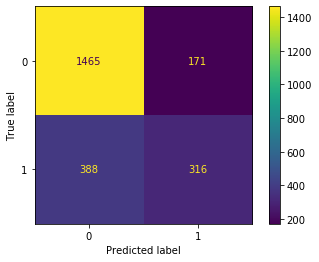

In [41]:
eval_model(rf, X_train, X_test, y_train, y_test)

# Overfit, but can tune
# Better accuracy similar to decision tree
# Recall is also similar
# Slightly lower f1 score

#### Decision: Continue with Decision Tree and Random Forest

### Data Version 2 - Additional Data Cleansing 

Too Many OHE Columns in baseline dataset to appropriately measure
Genre has inconsistent values - some apps are assigned 2 genres and there are some genres with <100 apps. Cleanse all Genre values to 1 genre and consolidate the <100 app genres via re-bucketing.

Get to 
- Numeric = ['Reviews', 'Size Trans']
- Ordinal = ['Installs']
- OHE = ['Category', 'Type', 'Content Rating', 'Genres']

#### Numeric - Translate Size to Numeric 'Size Trans'

In [42]:
# Preview values
df['Size']

0                       19M
1                       14M
2                      8.7M
3                       25M
4                      2.8M
                ...        
10834                  2.6M
10836                   53M
10837                  3.6M
10839    Varies with device
10840                   19M
Name: Size, Length: 9360, dtype: object

In [43]:
# Create new column for Size Type - this will be M (for MB) or k (for kb) for those that do not have 
# value 'Varies with device'
df['Size Type'] = 0

# For each value in Size, take the last character and put it in Size Type
for row in df['Size'].index:
    df['Size Type'][row] = df['Size'][row][-1]

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [44]:
# Check work; Varies with device 1637
df['Size Type'].value_counts()

M    7466
e    1637
k     257
Name: Size Type, dtype: int64

In [45]:
# Remove last character from Size, convert to numeric for math in Size Trans
for row in df['Size'].index:
    df['Size'][row] = df['Size'][row][:-1]

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [46]:
# Create Size Translation column and convert Size in MBs to kbs
df['Size Trans'] = 0

# For each row in Size, check Size Type. If M (for MB) multiply by 1000 to convert to kb, 
# otherwise k values stay the same and e for varies by devices stay at zero (will fill nulls)
for row in df['Size'].index:
    if df['Size Type'][row] == 'e':
        continue
    if df['Size Type'][row] == 'M':
        df['Size Trans'][row] = float(df['Size'][row]) * 1000
    if df['Size Type'][row] == 'k':
        df['Size Trans'][row] = df['Size'][row]

# Convert column to float
df['Size Trans'] = df['Size Trans'].astype(float)

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returnin

In [47]:
# Look at the Size Translations for those that did not have "Varies by device" value aka Size Trans != 0
df[df['Size Trans'] != 0]['Size Trans'].describe()
# mean is nearly 1.5x median, so there are outliers

count      7723.000000
mean      22970.456105
std       23449.628935
min           8.500000
25%        5300.000000
50%       14000.000000
75%       33000.000000
max      100000.000000
Name: Size Trans, dtype: float64

# Delete the row under this. 0 will mean varies and be a place to recommend further analysis

In [48]:
# Name variable for Size median for filling nulls
size_median = df[df['Size Trans'] != 0]['Size Trans'].median()

In [49]:
# Fill Size Trans nulls with median
df['Size Trans'].fillna(size_median)

0        19000.0
1        14000.0
2         8700.0
3        25000.0
4         2800.0
          ...   
10834     2600.0
10836    53000.0
10837     3600.0
10839        0.0
10840    19000.0
Name: Size Trans, Length: 9360, dtype: float64

In [50]:
# Review table with changes
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9360 entries, 0 to 10840
Data columns (total 14 columns):
App               9360 non-null object
Category          9360 non-null object
Reviews           9360 non-null int64
Size              9360 non-null object
Installs          9360 non-null object
Type              9360 non-null object
Content Rating    9360 non-null object
Genres            9360 non-null object
Last Updated      9360 non-null object
Current Ver       9360 non-null object
Android Ver       9360 non-null object
Pos Rating        9360 non-null int64
Size Type         9360 non-null object
Size Trans        9360 non-null float64
dtypes: float64(1), int64(2), object(11)
memory usage: 1.4+ MB


In [51]:
# Drop helper columns for final value to be used in model Size Trans
df = df.drop(columns=['Size Type', 'Size'], axis=1)

In [52]:
# Review new table
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9360 entries, 0 to 10840
Data columns (total 12 columns):
App               9360 non-null object
Category          9360 non-null object
Reviews           9360 non-null int64
Installs          9360 non-null object
Type              9360 non-null object
Content Rating    9360 non-null object
Genres            9360 non-null object
Last Updated      9360 non-null object
Current Ver       9360 non-null object
Android Ver       9360 non-null object
Pos Rating        9360 non-null int64
Size Trans        9360 non-null float64
dtypes: float64(1), int64(2), object(9)
memory usage: 1.2+ MB


#### Ordinal - Translate Installs to ordinal values

In [53]:
# Make Installs ordinal instead of categorical
df['Installs'].value_counts()

1,000,000+        1576
10,000,000+       1252
100,000+          1150
10,000+           1009
5,000,000+         752
1,000+             712
500,000+           537
50,000+            466
5,000+             431
100,000,000+       409
100+               309
50,000,000+        289
500+               201
500,000,000+        72
10+                 69
1,000,000,000+      58
50+                 56
5+                   9
1+                   3
Name: Installs, dtype: int64

In [54]:
# Combine those less than 500 and relabel
df['Installs'] = df['Installs'].replace(['1+', '5+', '10+', '50+', '100+', ], 'Less than 500')

In [55]:
# Check work
df['Installs'].value_counts()

1,000,000+        1576
10,000,000+       1252
100,000+          1150
10,000+           1009
5,000,000+         752
1,000+             712
500,000+           537
50,000+            466
Less than 500      446
5,000+             431
100,000,000+       409
50,000,000+        289
500+               201
500,000,000+        72
1,000,000,000+      58
Name: Installs, dtype: int64

In [56]:
# Ordinal mapping
df['Installs'] = df['Installs'].replace(['1+', '5+', '10+', '50+', '100+'], 'Less than 500')

In [57]:
# Check work
df['Installs'].value_counts()

1,000,000+        1576
10,000,000+       1252
100,000+          1150
10,000+           1009
5,000,000+         752
1,000+             712
500,000+           537
50,000+            466
Less than 500      446
5,000+             431
100,000,000+       409
50,000,000+        289
500+               201
500,000,000+        72
1,000,000,000+      58
Name: Installs, dtype: int64

In [58]:
# Map ordinal values
df['Installs'] = df['Installs'].map({'Less than 500': 0,
                                    '500+': 1,
                                    '1,000+': 2,
                                    '5,000+': 3,
                                    '10,000+': 4,
                                    '50,000+': 5,
                                    '100,000+': 6,
                                    '500,000+': 7,
                                    '1,000,000+': 8,
                                    '5,000,000+': 9,
                                    '10,000,000+': 10,
                                    '50,000,000+': 11,
                                    '100,000,000+': 12,
                                    '500,000,000+': 13,
                                    '1,000,000,000+': 14})

In [59]:
# Check results; matches counts table above
df['Installs'].value_counts()

8     1576
10    1252
6     1150
4     1009
9      752
2      712
7      537
5      466
0      446
3      431
12     409
11     289
1      201
13      72
14      58
Name: Installs, dtype: int64

#### Genre cleanse and bucketing

In [60]:
# Preview Genres values
df['Genres']

0                     Art & Design
1        Art & Design;Pretend Play
2                     Art & Design
3                     Art & Design
4          Art & Design;Creativity
                   ...            
10834                    Education
10836                    Education
10837                    Education
10839            Books & Reference
10840                    Lifestyle
Name: Genres, Length: 9360, dtype: object

In [61]:
# Some have multiple values, create lists
df['Genres'] = df['Genres'].str.split(';')

In [62]:
# View multi-genre value
df['Genres'][1]

['Art & Design', 'Pretend Play']

In [63]:
# Test references for for loop 
len(df['Genres'][1])

2

In [64]:
# Test references for for loop 
df['Genres'][1][0]

'Art & Design'

In [65]:
# Some apps have multiple Genres - take first listed genre as priority
for row in df['Genres'].index:
    df['Genres'][row] = df['Genres'][row][0]

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [66]:
# Check work - can see all strings and all first Genres
df['Genres']

0             Art & Design
1             Art & Design
2             Art & Design
3             Art & Design
4             Art & Design
               ...        
10834            Education
10836            Education
10837            Education
10839    Books & Reference
10840            Lifestyle
Name: Genres, Length: 9360, dtype: object

In [67]:
df['Genres'].value_counts()
# There are many Genres under 100, to help prevent overfitting - rebucket those under 100

Tools                      733
Entertainment              577
Education                  563
Action                     375
Productivity               351
Medical                    350
Sports                     337
Communication              329
Finance                    323
Photography                317
Lifestyle                  315
Personalization            312
Business                   303
Health & Fitness           299
Casual                     262
Social                     259
Shopping                   238
News & Magazines           233
Travel & Local             226
Arcade                     223
Simulation                 212
Dating                     195
Books & Reference          180
Video Players & Editors    163
Puzzle                     147
Maps & Navigation          124
Role Playing               119
Racing                     114
Food & Drink               109
Strategy                   107
Educational                103
Adventure                   89
House & 

In [68]:
df[df['Category'] =='EVENTS']['Genres'].value_counts()

Events    45
Name: Genres, dtype: int64

In [69]:
df[df['Genres'] == 'Lifestyle']

,App,Category,Reviews,Installs,Type,Content Rating,Genres,Last Updated,Current Ver,Android Ver,Pos Rating,Size Trans
1562,Dollhouse Decorating Games,LIFESTYLE,18968,9,Free,Teen,Lifestyle,"April 26, 2018",5.1,4.1 and up,0,32000.0
1563,metroZONE,LIFESTYLE,47497,10,Free,Everyone,Lifestyle,"June 8, 2018",5.3.0.54.7,5.0 and up,0,34000.0
1564,Easy Hair Style Design,LIFESTYLE,601,6,Free,Everyone,Lifestyle,"December 20, 2017",1.0,2.3 and up,0,5100.0
1565,Talking Babsy Baby: Baby Games,LIFESTYLE,140995,10,Free,Everyone,Lifestyle,"July 16, 2018",9.0,4.0 and up,0,100000.0
1566,"Black Wallpaper, AMOLED, Dark Background: Darkify",LIFESTYLE,51357,9,Free,Everyone,Lifestyle,"July 31, 2018",8.0,4.0 and up,1,80000.0
...,...,...,...,...,...,...,...,...,...,...,...,...
10719,Sona - Nær við allastaðni,LIFESTYLE,31,2,Free,Everyone,Lifestyle,"August 2, 2018",1.6.3,4.4 and up,0,25000.0
10742,GKPB FP Online Church,LIFESTYLE,32,2,Free,Everyone,Lifestyle,"December 31, 2017",0.7.1,4.4 and up,1,7900.0
10797,Fuel Rewards® program,LIFESTYLE,32433,8,Free,Everyone,Lifestyle,"June 26, 2018",2.9.1,5.0 and up,1,46000.0
10805,Scoreboard FR,LIFESTYLE,3,0,Free,Everyone,Lifestyle,"August 7, 2018",2.1,4.2 and up,0,15000.0


#### Genre Bucketing

In [70]:
# Genre buckets to reassign
# Adventure                   Action
# House & Home                Lifestyle
# Weather                     Travel & Local 
# Auto & Vehicles             Lifestyle
# Art & Design                Lifestyle
# Libraries & Demo            Entertainment
# Board                       Casual - games
# Comics                      Entertainment
# Parenting                   Lifestyle
# Card                        Casual - games
# Events                      Lifestyle
# Beauty                      Lifestyle
# Casino                      Casual - games
# Word                        Casual - games
# Trivia                      Casual - games
# Music                       Entertainment
# Music & Audio               Entertainment

In [71]:
# Code for mappings above

# Replace with Action
df['Genres'] = df['Genres'].replace(['Adventure'], 'Action')

# Replace with Travel & Local
df['Genres'] = df['Genres'].replace(['Weather'], 'Travel & Local')

# Replace with Lifestyle
df['Genres'] = df['Genres'].replace(['House & Home', 'Auto & Vehicles', 'Art & Design', 'Events', 'Beauty', 'Parenting'], 
                                    'Lifestyle')
# Replace with Entertainment
df['Genres'] = df['Genres'].replace(['Libraries & Demo', 'Comics', 'Music', 'Music & Audio'], 'Entertainment')

# Replace with Casual
df['Genres'] = df['Genres'].replace(['Board', 'Card', 'Casino', 'Word', 'Trivia'], 'Casual')

### Create new df for modeling

In [72]:
# New breakdown of column types for varying treatments before modeling
# Numerical columns
num_cols2 = ['Reviews', 'Size Trans']

# Ordinal columns
ord_cols = ['Installs']

# Categorical columns for OHE
ohe_cols2 = ['Category', 'Type', 'Content Rating', 'Genres']

#### Numeric Treatment - Scale

In [73]:
# Copy df for manipulation
scaled_features2 = df.copy()

In [74]:
# Scale num_col features
features2 = scaled_features2[num_cols2]
scaler2 = StandardScaler().fit(features2.values)
features2 = scaler2.transform(features2.values)

# Put into DF for concatenation
scaled_features2[num_cols2] = features2
scaled2 = scaled_features2[num_cols2]

# Check work
scaled2.head()

,Reviews,Size Trans
0,-0.163511,0.002038
1,-0.163254,-0.215189
2,-0.135735,-0.445451
3,-0.094991,0.262712
4,-0.163254,-0.701779


#### Ordinal Features

In [75]:
# Assign remapped Installs values to ordinal variable
ordinal = df['Installs']

#### Categorical Treatment (OHE)

In [76]:
# Copy df for manipulation
ohe_features2 = df.copy()

In [77]:
# Filter down to just ohe_cols
ohe_features2 = ohe_features2[ohe_cols2]

# OHE/Get Dummies
ohe_features2 = pd.get_dummies(ohe_features2)

# Preview, check work, 72 columns versus 500+ in Data Version 1
ohe_features2.head()

,Category_ART_AND_DESIGN,Category_AUTO_AND_VEHICLES,Category_BEAUTY,Category_BOOKS_AND_REFERENCE,Category_BUSINESS,Category_COMICS,Category_COMMUNICATION,Category_DATING,Category_EDUCATION,Category_ENTERTAINMENT,...,Genres_Racing,Genres_Role Playing,Genres_Shopping,Genres_Simulation,Genres_Social,Genres_Sports,Genres_Strategy,Genres_Tools,Genres_Travel & Local,Genres_Video Players & Editors
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Combine - Data Version 2
- Numeric = ['Reviews', 'Size Trans']
- Ordinal = ['Installs']
- OHE = ['Category', 'Type', 'Content Rating', 'Genres']

In [78]:
# Combine scaled numerical, OHE categoricals, and target into one df
preprocessed2 = pd.concat([scaled2, ordinal, ohe_features2, y], axis=1)

In [79]:
preprocessed2.columns

Index(['Reviews', 'Size Trans', 'Installs', 'Category_ART_AND_DESIGN',
       'Category_AUTO_AND_VEHICLES', 'Category_BEAUTY',
       'Category_BOOKS_AND_REFERENCE', 'Category_BUSINESS', 'Category_COMICS',
       'Category_COMMUNICATION', 'Category_DATING', 'Category_EDUCATION',
       'Category_ENTERTAINMENT', 'Category_EVENTS', 'Category_FAMILY',
       'Category_FINANCE', 'Category_FOOD_AND_DRINK', 'Category_GAME',
       'Category_HEALTH_AND_FITNESS', 'Category_HOUSE_AND_HOME',
       'Category_LIBRARIES_AND_DEMO', 'Category_LIFESTYLE',
       'Category_MAPS_AND_NAVIGATION', 'Category_MEDICAL',
       'Category_NEWS_AND_MAGAZINES', 'Category_PARENTING',
       'Category_PERSONALIZATION', 'Category_PHOTOGRAPHY',
       'Category_PRODUCTIVITY', 'Category_SHOPPING', 'Category_SOCIAL',
       'Category_SPORTS', 'Category_TOOLS', 'Category_TRAVEL_AND_LOCAL',
       'Category_VIDEO_PLAYERS', 'Category_WEATHER', 'Type_Free', 'Type_Paid',
       'Content Rating_Adults only 18+', 'Content R

#### Model 5 - Decision Tree2 (Data Version 2) <a id="Model_5"></a>

Class weight = 'balanced' to account for 68/32 split of Target

In [80]:
# X and y split of preprocessed 
X = preprocessed2.drop(columns=['Pos Rating'], axis=1)
y = preprocessed2['Pos Rating']

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [82]:
# Instantiate
dt2 = DecisionTreeClassifier(class_weight='balanced', random_state=42)

# Fit
dt2.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

Train Scores
------------
Accuracy: 0.9997150997150998
Recall: 1.0
F1 Score: 0.9995557529986673
--------------------
Test Scores
-----------
Accuracy: 0.714957264957265
Recall: 0.5909090909090909
Recall Mean Cross Val 3-Fold: 0.5373333333333333
F1 Score: 0.5550366911274183


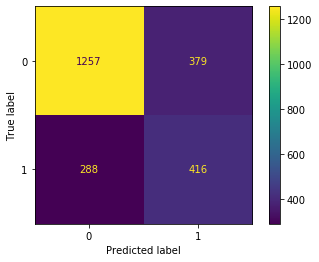

In [83]:
eval_model(dt2, X_train, X_test, y_train, y_test)

# Overfit, but can tune
# Accuracy similar to original decision tree
# Recall at highest at 0.59, validation lower at 0.53
# Similar f1 to original decision tree

### Tune Decision Tree

In [84]:
# What is current depth of overfit tree
dt2.tree_.max_depth

53

#### Model 6 - Decision Tree3 (Data Version 2) with half depth <a id="Model_6"></a>

Doing this to understand best range of max_depth parameters for GridSearch

In [85]:
# Instantiate
dt3 = DecisionTreeClassifier(class_weight='balanced', random_state=42,
                            max_depth = 31)

# Fit
dt3.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=31, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

Train Scores
------------
Accuracy: 0.9816239316239316
Recall: 0.9671111111111111
F1 Score: 0.9712117830841329
--------------------
Test Scores
-----------
Accuracy: 0.7136752136752137
Recall: 0.5823863636363636
Recall Mean Cross Val 3-Fold: 0.5377777777777778
F1 Score: 0.5503355704697988


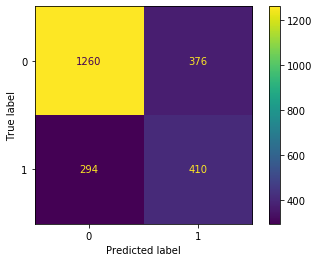

In [86]:
eval_model(dt3, X_train, X_test, y_train, y_test)

# Less overfit but still needs help 
# in GridSearch, do range around this, aim for lower number as this is still very overfit
# Similar recall and validation
# Same F1 as with full depth

#### GridSearch

In [87]:
param_dict = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, 15, 20, 25, 30, 35],
    'min_samples_split': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
    'min_samples_leaf': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
}

In [88]:
grid = GridSearchCV(dt3,
                   param_grid = param_dict,
                   cv=5,
                   verbose=1)

grid.fit(X_train, y_train)

Fitting 5 folds for each of 1400 candidates, totalling 7000 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 7000 out of 7000 | elapsed:  3.9min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=31,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=42,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'crit

In [89]:
grid.best_params_

{'criterion': 'entropy',
 'max_depth': 10,
 'min_samples_leaf': 20,
 'min_samples_split': 2}

In [90]:
grid.best_score_

0.6958689458689459

#### Model 7 - GridSearch Decision Tree <a id="Model_7"></a>

In [91]:
# Instantiate
dt_grid = DecisionTreeClassifier(class_weight='balanced',
                             criterion = 'entropy',
                             max_depth = 10,
                             min_samples_leaf  = 20,
                             min_samples_split = 2)

# Fit
dt_grid.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=10, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=20,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       presort='deprecated', random_state=None,
                       splitter='best')

Train Scores
------------
Accuracy: 0.7215099715099715
Recall: 0.5542222222222222
F1 Score: 0.5605754102045403
--------------------
Test Scores
-----------
Accuracy: 0.6863247863247863
Recall: 0.4928977272727273
Recall Mean Cross Val 3-Fold: 0.5306666666666667
F1 Score: 0.48599439775910364


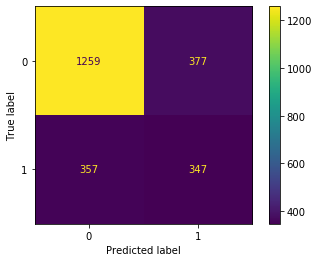

In [92]:
eval_model(dt_grid, X_train, X_test, y_train, y_test)
# Much less overfit - but accuracy down .2 - Same as random guess
# Recall much lower from 0.58 to 0.49 - but validation at 0.53

#### Model 8 - GridSearch Random Forest <a id="Model_8"></a>

In [93]:
# X and y split of preprocessed 
X = preprocessed2.drop(columns=['Pos Rating'], axis=1)
y = preprocessed2['Pos Rating']

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [95]:
# Instantiate
rf_grid = RandomForestClassifier(class_weight='balanced',
                             criterion = 'entropy',
                             max_depth = 10,
                             min_samples_leaf  = 20,
                             min_samples_split = 2)

# Fit
rf_grid.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=20, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Train Scores
------------
Accuracy: 0.672934472934473
Recall: 0.5786666666666667
F1 Score: 0.5314285714285715
--------------------
Test Scores
-----------
Accuracy: 0.6666666666666666
Recall: 0.5681818181818182
Recall Mean Cross Val 3-Fold: 0.5573333333333333
F1 Score: 0.5063291139240507


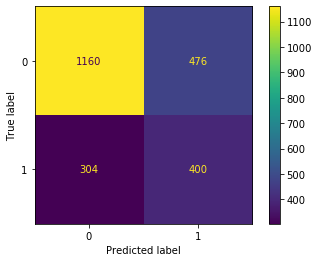

In [96]:
eval_model(rf_grid, X_train, X_test, y_train, y_test)
# Slightly overfit
# Accuracy is less than random guess although recall is at highest
# F1 also at similar highest

### Data Version 3 - Additional Ordinal Mapping

There is opportunity for Content Rating to be mapped to ordinal values. Edit this in dataset and retry top models.

Get to 
- Numeric = ['Reviews', 'Size Trans']
- Ordinal = ['Installs', 'Content Rating']
- OHE = ['Category', 'Type', 'Genres']

In [97]:
df['Content Rating'].value_counts()

Everyone           7414
Teen               1084
Mature 17+          461
Everyone 10+        397
Adults only 18+       3
Unrated               1
Name: Content Rating, dtype: int64

In [98]:
# Ordinal mapping
df['Content Rating'] = df['Content Rating'].map({'Everyone': 0, 'Everyone 10+': 1, 'Teen': 2,
                                                 'Mature 17+': 3, 'Adults only 18+': 4, 'Unrated': 5})

In [99]:
df['Content Rating'].value_counts()

0    7414
2    1084
3     461
1     397
4       3
5       1
Name: Content Rating, dtype: int64

### Create new df for modeling

In [100]:
# New breakdown of column types for varying treatments before modeling
# Numerical columns, same as Data Version 2, use scaled2

# Ordinal columns
ord_cols2 = ['Installs', 'Content Rating']

# Categorical columns for OHE
ohe_cols3 = ['Category', 'Type', 'Genres']

#### Ordinal Features

In [101]:
# Assign remapped Content rating values to ordinal variable
ordinal2 = df[['Installs', 'Content Rating']]

#### Categorical Treatment (OHE)

In [102]:
# Copy df for manipulation
ohe_features3 = df.copy()

In [103]:
# Filter down to just ohe_cols
ohe_features3 = ohe_features3[ohe_cols3]

# OHE/Get Dummies
ohe_features3 = pd.get_dummies(ohe_features3)

# Preview, check work, 66 columns versus 72 in Data Version 1
ohe_features3.head()

,Category_ART_AND_DESIGN,Category_AUTO_AND_VEHICLES,Category_BEAUTY,Category_BOOKS_AND_REFERENCE,Category_BUSINESS,Category_COMICS,Category_COMMUNICATION,Category_DATING,Category_EDUCATION,Category_ENTERTAINMENT,...,Genres_Racing,Genres_Role Playing,Genres_Shopping,Genres_Simulation,Genres_Social,Genres_Sports,Genres_Strategy,Genres_Tools,Genres_Travel & Local,Genres_Video Players & Editors
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Combine - Data Version 3
- Numeric = ['Reviews', 'Size Trans']
- Ordinal = ['Installs', 'Content Rating']
- OHE = ['Category', 'Type', 'Genres']

In [104]:
# Combine scaled numerical, OHE categoricals, and target into one df
preprocessed3 = pd.concat([scaled2, ordinal2, ohe_features3, y], axis=1)

In [105]:
preprocessed3.columns

Index(['Reviews', 'Size Trans', 'Installs', 'Content Rating',
       'Category_ART_AND_DESIGN', 'Category_AUTO_AND_VEHICLES',
       'Category_BEAUTY', 'Category_BOOKS_AND_REFERENCE', 'Category_BUSINESS',
       'Category_COMICS', 'Category_COMMUNICATION', 'Category_DATING',
       'Category_EDUCATION', 'Category_ENTERTAINMENT', 'Category_EVENTS',
       'Category_FAMILY', 'Category_FINANCE', 'Category_FOOD_AND_DRINK',
       'Category_GAME', 'Category_HEALTH_AND_FITNESS',
       'Category_HOUSE_AND_HOME', 'Category_LIBRARIES_AND_DEMO',
       'Category_LIFESTYLE', 'Category_MAPS_AND_NAVIGATION',
       'Category_MEDICAL', 'Category_NEWS_AND_MAGAZINES', 'Category_PARENTING',
       'Category_PERSONALIZATION', 'Category_PHOTOGRAPHY',
       'Category_PRODUCTIVITY', 'Category_SHOPPING', 'Category_SOCIAL',
       'Category_SPORTS', 'Category_TOOLS', 'Category_TRAVEL_AND_LOCAL',
       'Category_VIDEO_PLAYERS', 'Category_WEATHER', 'Type_Free', 'Type_Paid',
       'Genres_Action', 'Genres_A

#### Model 9 - Decision Tree with Data Version 3 <a id="Model_9"></a>

In [106]:
# X and y split of preprocessed 
X = preprocessed3.drop(columns=['Pos Rating'], axis=1)
y = preprocessed3['Pos Rating']

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [108]:
# Instantiate
dt4 = DecisionTreeClassifier(class_weight='balanced')

# Fit
dt4.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

Train Scores
------------
Accuracy: 0.9997150997150998
Recall: 1.0
F1 Score: 0.9995557529986673
--------------------
Test Scores
-----------
Accuracy: 0.7051282051282052
Recall: 0.5653409090909091
Recall Mean Cross Val 3-Fold: 0.5342222222222223
F1 Score: 0.5356662180349933


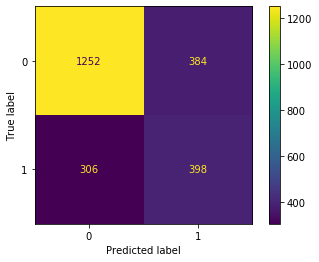

In [109]:
eval_model(dt4, X_train, X_test, y_train, y_test)
# Overfit, but can tune
# Similar accuracy to previous untuned decision trees
# Recall at 0.56
# F1 up at 0.53

In [110]:
# What is current depth of overfit tree
dt4.tree_.max_depth

58

#### Model 10 - Decision Tree3 (Data Version 3) with half depth <a id="Model_10"></a>

Doing this to understand best range of max_depth parameters for GridSearch

In [111]:
# Instantiate
dt5 = DecisionTreeClassifier(class_weight='balanced', random_state=42,
                            max_depth = 29)

# Fit
dt5.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=29, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

Train Scores
------------
Accuracy: 0.975925925925926
Recall: 0.9635555555555556
F1 Score: 0.9624861265260821
--------------------
Test Scores
-----------
Accuracy: 0.7123931623931624
Recall: 0.5710227272727273
Recall Mean Cross Val 3-Fold: 0.5399999999999999
F1 Score: 0.5443466486120515


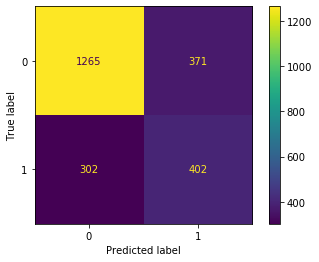

In [112]:
eval_model(dt5, X_train, X_test, y_train, y_test)

# Not mcuh less overfit but still needs help 
# in GridSearch, do range around this, aim for lower number as this is still very overfit
# Similar recall and validation
# Same F1 as with full depth

#### Grid Search 3 - Expanding min_samples_split for higher range (previously 20) with Data Version 3

In [113]:
param_dict3 = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, 15, 20, 25, 30, 35],
    'min_samples_split': [15, 20, 25, 30, 35, 40],
    'min_samples_leaf': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
}

In [114]:
grid = GridSearchCV(dt4,
                   param_grid = param_dict,
                   cv=5,
                   verbose=1)

grid.fit(X_train, y_train)

Fitting 5 folds for each of 1400 candidates, totalling 7000 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 7000 out of 7000 | elapsed:  3.9min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'

In [115]:
grid.best_params_

{'criterion': 'entropy',
 'max_depth': 10,
 'min_samples_leaf': 20,
 'min_samples_split': 2}

In [116]:
grid.best_score_
# 1% better than random guess

0.6937321937321937

Decision: GridSearch output is consistent. In addition to class_weight = 'balanced', below parameters should be set:
- 'criterion': 'entropy'
- 'max_depth': 10
- 'min_samples_leaf': 20
- 'min_samples_split': 2

#### Model 11 - GridSearch2 Decision Tree <a id="Model_11"></a>

In [117]:
# Instantiate
dt_grid2 = DecisionTreeClassifier(class_weight='balanced',
                             criterion = 'entropy',
                             max_depth = 10,
                             min_samples_leaf  = 20, #The minimum number of samples required to be at a leaf node.
                             min_samples_split = 2)

# Fit
dt_grid2.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=10, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=20,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       presort='deprecated', random_state=None,
                       splitter='best')

Train Scores
------------
Accuracy: 0.7215099715099715
Recall: 0.5542222222222222
F1 Score: 0.5605754102045403
--------------------
Test Scores
-----------
Accuracy: 0.6863247863247863
Recall: 0.4928977272727273
Recall Mean Cross Val 3-Fold: 0.5315555555555557
F1 Score: 0.48599439775910364


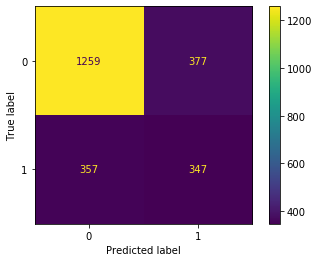

In [118]:
eval_model(dt_grid2, X_train, X_test, y_train, y_test)
# Much less overfit - but accuracy down .2 - Same as random guess
# Recall much lower from 0.58 to 0.49 - but validation at 0.53

#### Model 12 - GridSearch2 Random Forest <a id="Model_13"></a>

In [119]:
# Instantiate
rf_grid2 = RandomForestClassifier(class_weight='balanced',
                             criterion = 'entropy',
                             max_depth = 10,
                             min_samples_leaf  = 20,
                             min_samples_split = 2)

# Fit
rf_grid2.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=20, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Train Scores
------------
Accuracy: 0.6713675213675213
Recall: 0.5946666666666667
F1 Score: 0.5370258880192655
--------------------
Test Scores
-----------
Accuracy: 0.6692307692307692
Recall: 0.5809659090909091
Recall Mean Cross Val 3-Fold: 0.5573333333333333
F1 Score: 0.513819095477387


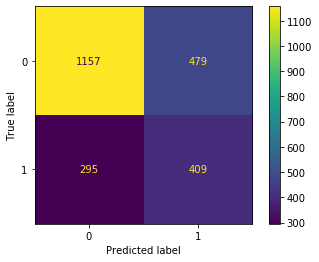

In [120]:
eval_model(rf_grid2, X_train, X_test, y_train, y_test)
# Not overfit for once, but accuracy is less than random guess 
# although recall is at highest
# F1 also at similar highest

## Feature Importance on Top Models

The best performing models either have:
1. An accuracy score 1-2% above a random guess and a 50% recall score 
OR
2. A 56-58% recall score (and similar cross validation scores for recall, and an accuracy score 2% below a random guess. 

Models explored below include:
- Model 11, dt_grid2, which falls into bucket #1 above
- Model 12, rf_grid2, which falls into bucket #2 above

Looking to feature importance across both to look into any consistency.

### Model 11 (dt_grid2) Feature Importance <a id="Model_11_FI"></a>

#### Baseline

In [121]:
# Top 10 Feature Importance
coef = dt_grid2.feature_importances_
d = dict(zip(X.columns, coef))
sorted_dict = dict( sorted(d.items(), key=operator.itemgetter(1),reverse=True)[:10])
sorted_dict
# Reviews and Installs are main drivers
# Size next largest

{'Reviews': 0.3514917474926996,
 'Installs': 0.2874481218337568,
 'Size Trans': 0.11458367450040421,
 'Type_Free': 0.05933202994323856,
 'Genres_Health & Fitness': 0.03420882182816005,
 'Category_TRAVEL_AND_LOCAL': 0.02509496675294812,
 'Category_TOOLS': 0.02102407444211158,
 'Content Rating': 0.01739450044668302,
 'Genres_Education': 0.0108069190939718,
 'Category_SOCIAL': 0.010230815349171177}

#### eli5

In [122]:
perm = PermutationImportance(dt_grid2, cv = None, refit = False, n_iter = 50).fit(X_train, y_train)
perm_imp_eli5 = pd.DataFrame(X_train.columns, perm.feature_importances_)
perm_imp_eli5.sort_index(ascending=False)
# Reviews and Installs are main drivers

,0
0.129920,Reviews
0.116821,Installs
0.021744,Type_Free
0.016923,Size Trans
0.009678,Content Rating
...,...
0.000000,Category_PRODUCTIVITY
0.000000,Category_SHOPPING
0.000000,Category_SPORTS
0.000000,Category_TOOLS


#### rfpimp

In [123]:
perm_imp_rfpimp = permutation_importances(dt_grid2, X_train, y_train, r2)
perm_imp_rfpimp
# Reviews and Installs are main drivers

,Importance
Feature,
Installs,0.791099
Reviews,0.751590
Size Trans,0.130472
Content Rating,0.051454
Type_Paid,0.040428
...,...
Category_SOCIAL,0.000000
Category_SPORTS,0.000000
Category_TOOLS,0.000000


#### Drop column feature importance

In [124]:
importances_df = drop_col_feat_imp(dt_grid2, X_train, y_train, random_state = 42)
importances_df.sort_index(ascending=False)
# Reviews, Installs and Size are big drivers 
# much higher here than other checks

,0
0.060399,Reviews
0.052849,Installs
0.044017,Size Trans
0.002564,Genres_Action
0.001852,Genres_Education
...,...
0.000000,Category_SPORTS
0.000000,Category_TOOLS
0.000000,Genres_Video Players & Editors
-0.002137,Category_GAME


### Model 12 (rf_grid2) Feature Importance <a id="Model_12_FI"></a>

#### Baseline

In [125]:
# Top 10 Feature Importance
coef = rf_grid2.feature_importances_
d = dict(zip(X.columns, coef))
sorted_dict = dict( sorted(d.items(), key=operator.itemgetter(1),reverse=True)[:10])
sorted_dict
# Reviews and Installs are main drivers
# Size next largest
# All have lower influence than in Decision Tree dt_grid2 above

{'Reviews': 0.2806939751351103,
 'Installs': 0.23607909460983045,
 'Size Trans': 0.08130752016258495,
 'Genres_Health & Fitness': 0.040194403427215114,
 'Category_HEALTH_AND_FITNESS': 0.03174114489034901,
 'Type_Free': 0.02953003825624812,
 'Type_Paid': 0.0271303832002088,
 'Content Rating': 0.025052694889983664,
 'Category_TOOLS': 0.022898409037890397,
 'Genres_Tools': 0.022496419454335566}

#### eli5

In [126]:
perm = PermutationImportance(rf_grid2, cv = None, refit = False, n_iter = 50).fit(X_train, y_train)
perm_imp_eli5 = pd.DataFrame(X_train.columns, perm.feature_importances_)
perm_imp_eli5.sort_index(ascending=False)
# Reviews and Installs are main drivers

,0
0.055285,Reviews
0.032880,Installs
0.007171,Type_Free
0.006430,Type_Paid
0.004382,Genres_Health & Fitness
...,...
-0.000350,Category_GAME
-0.000533,Category_EDUCATION
-0.001191,Genres_Communication
-0.001627,Category_FAMILY


#### rfpimp

In [127]:
perm_imp_rfpimp = permutation_importances(rf_grid2, X_train, y_train, r2)
perm_imp_rfpimp
# Reviews and Installs are main drivers

,Importance
Feature,
Reviews,0.293542
Installs,0.161766
Type_Free,0.030899
Type_Paid,0.025446
Genres_Health & Fitness,0.019994
...,...
Genres_Photography,-0.001818
Genres_Travel & Local,-0.002726
Category_COMMUNICATION,-0.005453


#### Drop column feature importance

In [128]:
importances_df = drop_col_feat_imp(rf_grid2, X_train, y_train, random_state = 42)
importances_df.sort_index(ascending=False)
# Installs is top driver, but very small time in comparison to 
# other feature importance checks

,0
0.012393,Installs
0.002707,Genres_Shopping
0.002279,Genres_Role Playing
0.002279,Genres_Personalization
0.001709,Genres_Lifestyle
...,...
-0.004558,Category_AUTO_AND_VEHICLES
-0.004701,Category_BUSINESS
-0.005271,Type_Paid
-0.005840,Genres_Communication


#### **Learning:**
Across dt_grid and rf_grid2, 5 out 6 feature importance checks highlight Review and Installs followed by Size of the app as model drivers.

Although the model is not in a final versioning to be utilized in day-to-day decisions, the consistency from this version can be generally applied to say that marketing, promotion, and adoption of the app is foundationally important.

VC would want CEOs with strong marketing background, a network with these skills, and/or teams that have this expertise.

### Analysis<a id="Analysis"></a>

Look into details of Installs, Reviews, and Size of apps that are Positively Rated in the data set (target = 1).

#### Installs - most consistent driver <a id="Installs"></a>

In [129]:
# Map ordinal values back to original categorical values
df['Installs'] = df['Installs'].map({0:'Less than 500',
                                    1: '500+',
                                    2: '1,000+',
                                    3: '5,000+',
                                    4: '10,000+',
                                    5: '50,000+',
                                    6: '100,000+',
                                    7: '500,000+',
                                    8: '1,000,000+',
                                    9: '5,000,000+',
                                    10: '10,000,000+',
                                    11: '50,000,000+',
                                    12: '100,000,000+',
                                    13: '500,000,000+',
                                    14: '1,000,000,000+'})

In [130]:
# Filter down to only those with Positive Ratings (target = 1)
installs_df = pd.DataFrame(df[df['Pos Rating'] == 1]['Installs'].value_counts()).reset_index()

In [131]:
# Preview new df
installs_df

,index,Installs
0,"10,000,000+",431
1,"1,000,000+",418
2,"100,000+",297
3,Less than 500,294
4,"1,000+",276
5,"10,000+",270
6,"5,000,000+",190
7,"100,000,000+",166
8,"500,000+",158
9,"5,000+",115


In [132]:
# Create helper column that will put Install categories in order
installs_df['Install Num'] = 0

# For loop to place numerical versions of categories into Install Num column
for row in installs_df.index:
    if installs_df['index'][row] == 'Less than 500':
        installs_df['Install Num'][row] = 500
    else:
        installs_df['Install Num'][row] = int(installs_df['index'][row][:-1].replace(',',''))

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [133]:
# Sort by new Install Num helper column and reset the index
installs_df = installs_df.sort_values(by='Install Num', ascending=True).reset_index(drop=True)

In [134]:
# Drop helper column
installs_df = installs_df.drop(columns='Install Num', axis=1)

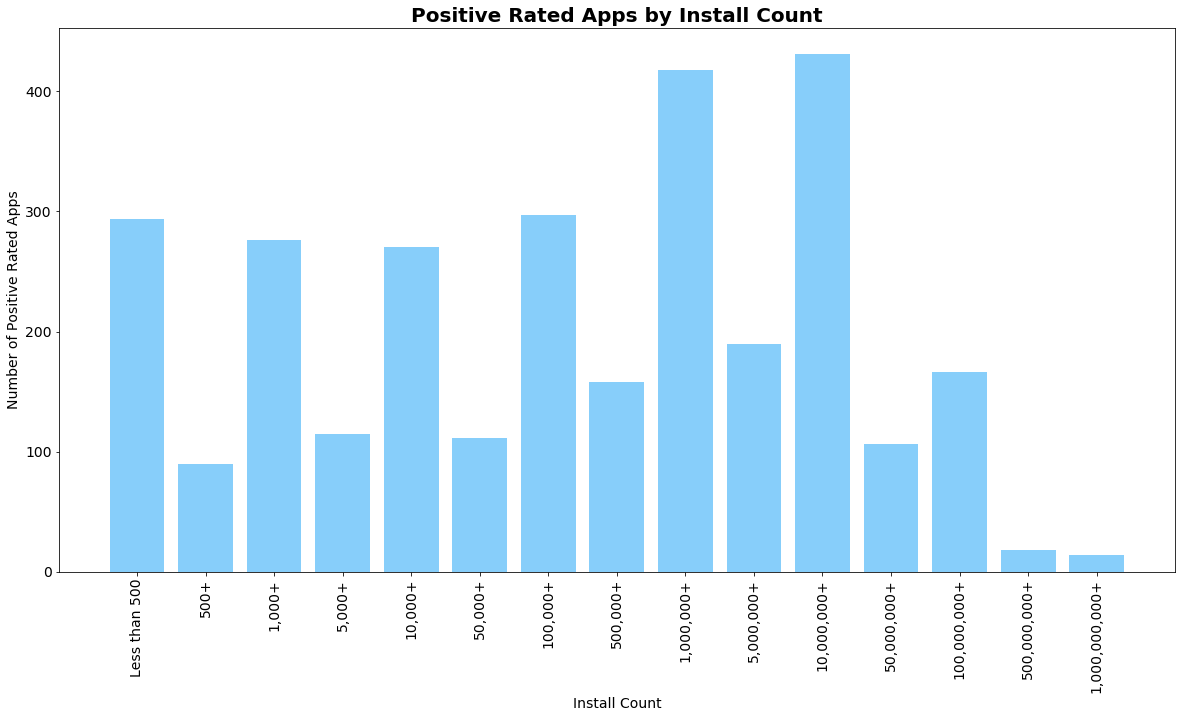

In [135]:
# Plot bar chart with counts per category
x = installs_df['index']
y = installs_df['Installs']
plt.figure (figsize=(20,10))
plt.bar(x, y, color='lightskyblue')
plt.title('Positive Rated Apps by Install Count', fontsize=20, fontweight="bold")
plt.xlabel('Install Count', fontsize=14)
plt.xticks(rotation=90, fontsize=14)
plt.ylabel('Number of Positive Rated Apps', fontsize=14)
plt.yticks(fontsize=14)
plt.savefig("images/1_install_count_for_pos_apps")
plt.show()
# Not necessarily more installs = more positively reviewed app
# 1mm-1.5mm installs is sweet spot
# 10mm-50mm installs has second most (much larger range)
# More installs leaves more room for negative reviews

#### Reviews - strongest and second most consistent driver (5 out of 6)<a id="Revs"></a>

In [136]:
# Filter down to only those with Positive Ratings (target = 1)
pos_rated = df[df['Pos Rating'] == 1]

In [137]:
# Explore Reviews distribution
pos_rated['Reviews'].describe().apply(lambda x: format(x, 'f'))

count        2954.000000
mean       784696.629316
std       3827048.578984
min             1.000000
25%           100.000000
50%          8358.500000
75%        172508.000000
max      66577446.000000
Name: Reviews, dtype: object

In [138]:
less_than_two_mm = pos_rated[pos_rated['Reviews'] <= 2000000]['Reviews']

In [139]:
len(less_than_two_mm)/2954

0.9285714285714286

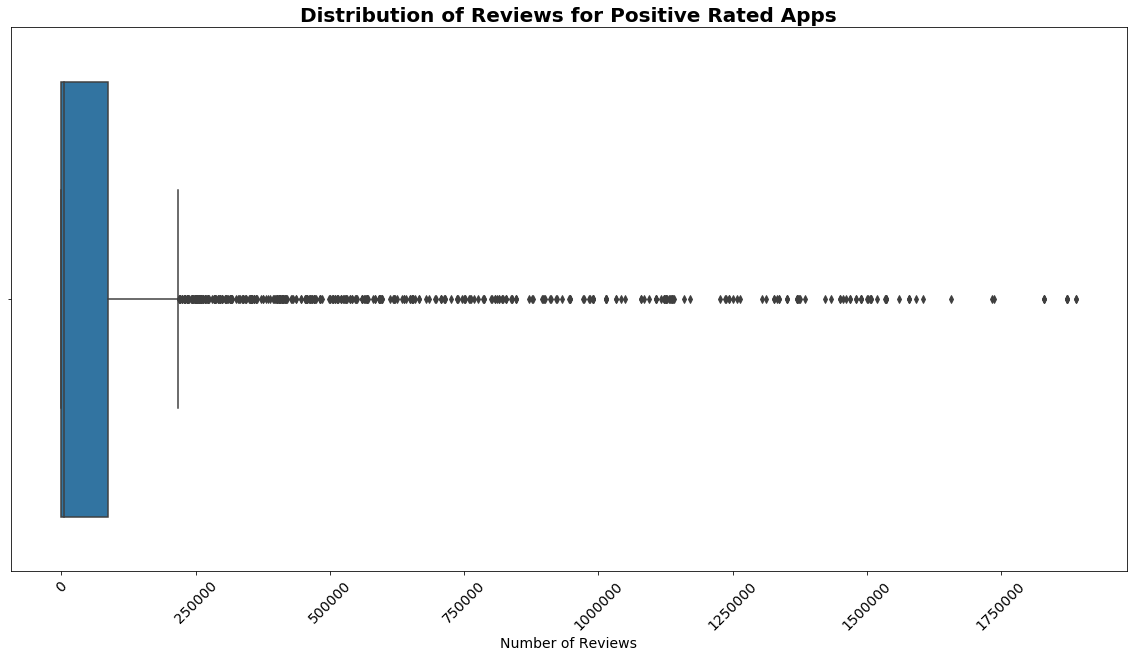

In [140]:
# Plot 92% of Positively Rated Reviews population
plt.figure(figsize=(20,10))
sns.boxplot(less_than_two_mm)
plt.title('Distribution of Reviews for Positive Rated Apps', fontsize=20, fontweight="bold")
plt.xlabel('Number of Reviews', fontsize=14)
plt.xticks(rotation=45, fontsize=14)
plt.savefig("images/2_review_dist_for_pos_apps")
plt.show()

In [141]:
# What % is accounted for less than or equal to 100k reviews
len(pos_rated[pos_rated['Reviews'] <=100000])/2954

0.7071767095463778

In [142]:
# Create filtered df
reviews_zoom = pos_rated[pos_rated['Reviews'] <=100000]

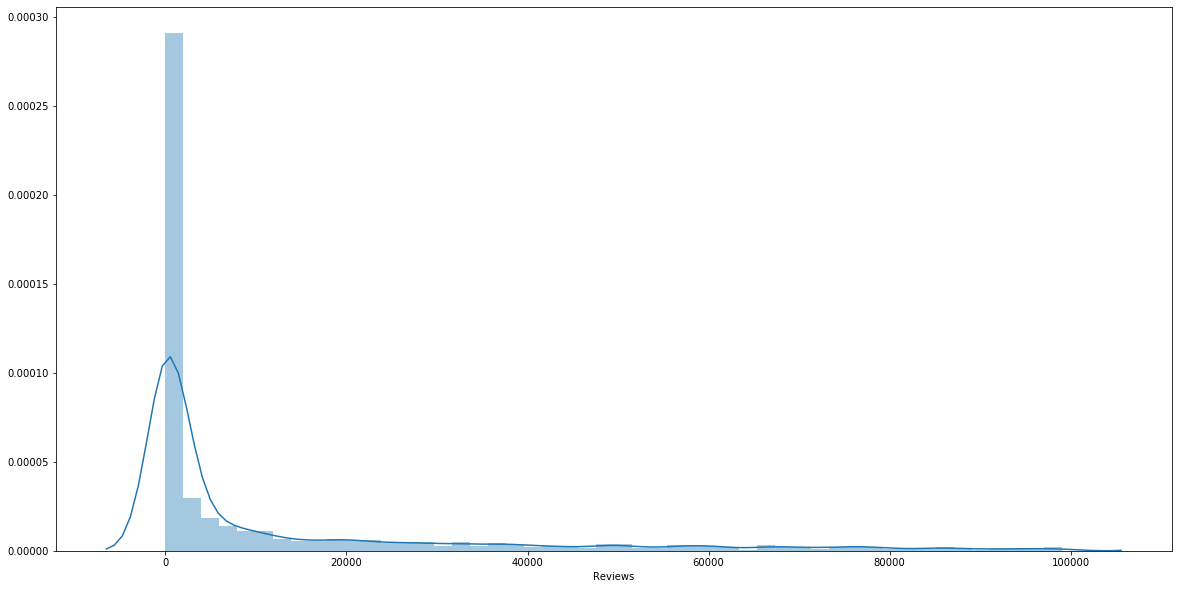

In [143]:
# Plot this 70%
plt.figure(figsize=(20, 10))
sns.distplot(reviews_zoom['Reviews'])

In [144]:
# Spike is on lowest end, create further filtered df
reviews_zoom2 = pos_rated[pos_rated['Reviews'] <=500]

In [145]:
len(reviews_zoom2)/2954

0.33818551117129314

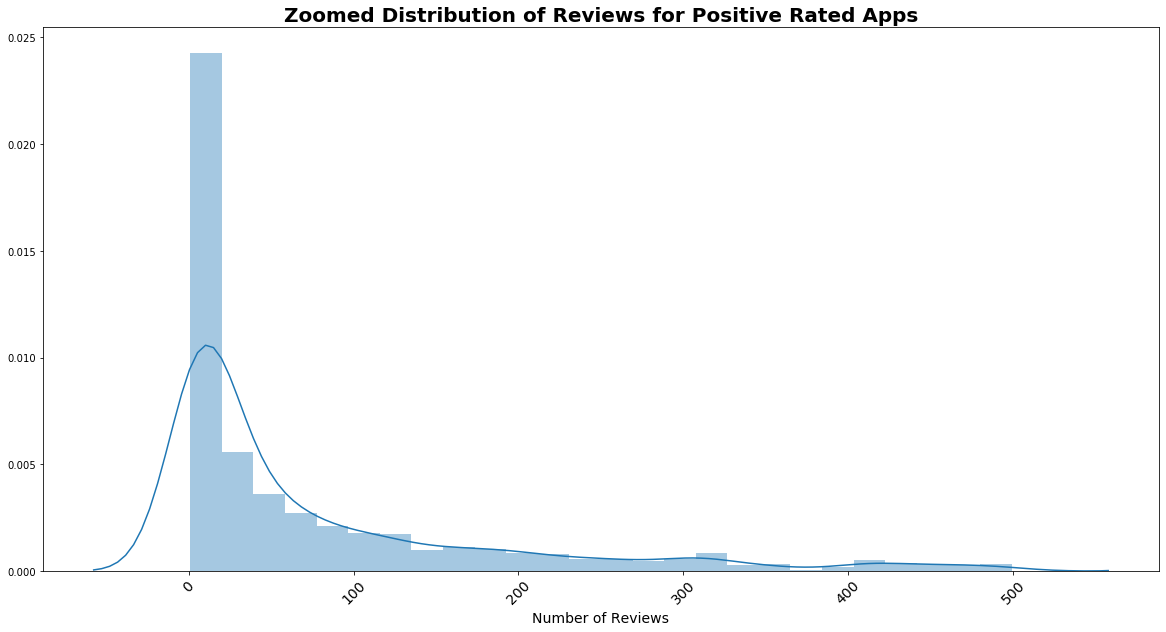

In [146]:
# Plot the 34%
plt.figure(figsize=(20, 10))
sns.distplot(reviews_zoom2['Reviews'], hist=True)
plt.title('Zoomed Distribution of Reviews for Positive Rated Apps', fontsize=20, fontweight="bold")
plt.xlabel('Number of Reviews', fontsize=14)
plt.xticks(rotation=45, fontsize=14)
plt.savefig("images/3_review_dist_zoom_for_pos_apps")
plt.show()

#### **Learning:**
Plots above are showing that the apps with positive ratings are the ones with 0-20 reviews. This could be a space for further iteration as the logic does not check out that higher installs, but very low number of reviews predict a successful app.

#### Size - third most consistent driver <a id="Size"></a>

In [147]:
# Review distribution of Size Trans which is Size in kb
pos_rated['Size Trans'].describe()
# 0 means varies by device and this would drag down mean
# Opportunity to edit this in further model development
# Mean is 2x that of median so have extreme outliers (high end)

count      2954.000000
mean      19818.388795
std       24058.485396
min           0.000000
25%        3000.000000
50%       10000.000000
75%       26750.000000
max      100000.000000
Name: Size Trans, dtype: float64

In [148]:
# Review distribution of Size Trans which is Size in kb of those that
pos_rated[pos_rated['Size Trans'] !=0]['Size Trans'].describe()
# Mean is 1.5x that of median so have outliers (high end)

count      2459.000000
mean      23807.857056
std       24502.125727
min           8.500000
25%        5700.000000
50%       14000.000000
75%       32000.000000
max      100000.000000
Name: Size Trans, dtype: float64

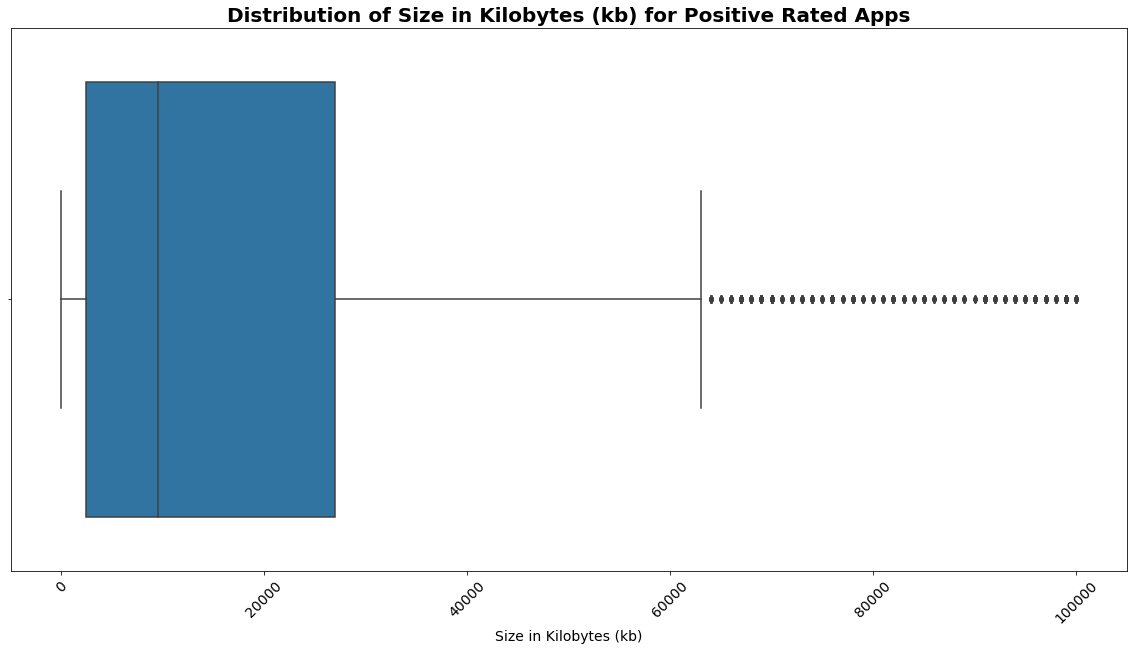

In [149]:
# Visualize distribution
plt.figure(figsize=(20,10))
sns.boxplot(df['Size Trans'])
plt.title('Distribution of Size in Kilobytes (kb) for Positive Rated Apps', fontsize=20, fontweight="bold")
plt.xlabel('Size in Kilobytes (kb)', fontsize=14)
plt.xticks(rotation=45, fontsize=14)
plt.savefig("images/4_size_dist_for_pos_apps")
plt.show()
# 3,000-26,750 kbs is general range
# 10,000 kbs median
# average Android app is 14,600 kbs - more advanced phones with more baseline storage
# probably enabled this growth/support of larger apps
# source: https://shafi.com.au/mobile%20apps%20facts/iphone/android/big%204%20bank/2020/01/06/mobile-apps-fact-file-size.html

In [150]:
# Cite some apps  in presentation
# Sephora, SlickDeals, Fuel Rewards, Udemy - Online Courses
# LinkedIn Learning: Online Courses to Learn Skills, Fitbit Coach
# Redfin Real Estate, JOANN - Crafts & Coupons
pos_rated[(pos_rated['Installs'] == '1,000,000+') & 
         (pos_rated['Size Trans'] !=0)]['App'].values
# Can see from values that there are app records duplicated
# Another opportunity to better model
# Also can visit correlations - some Genres and Categories are named the same
# Opportunity to bucket or just use one for more focused impact on model

array(['Tickets + PDA 2018 Exam', 'auto fines',
       'Used car is the first car - used car purchase, used car quotation, dealer information to',
       'ipsy: Makeup, Beauty, and Tips',
       'Sephora: Skin Care, Beauty Makeup & Fragrance Shop',
       'Free Books - Spirit Fanfiction and Stories',
       'ReadEra – free ebook reader', 'eBoox: book reader fb2 epub zip',
       'Job Search by ZipRecruiter', 'Google Analytics',
       'Google Analytics',
       'GANMA! - All original stories free of charge for all original comics',
       'Tapas – Comics, Novels, and Stories', 'Should I Answer?',
       'Email TypeApp - Mail App', 'Learn Spanish - Español',
       'English for beginners', 'Flame - درب عقلك يوميا',
       'Learn Japanese, Korean, Chinese Offline & Free',
       'PINKFONG Baby Shark', 'Udemy - Online Courses',
       'edX - Online Courses by Harvard, MIT & more',
       'Udemy - Online Courses', 'Learn C++', 'Learn JavaScript',
       'Learn Java', 'Learn HTML', 'Learn S

## Data Analysis Learnings <a id="DAL"></a>

When looking across the two most successful models an app's number of installs and number of reviews were the biggest drivers along with the size of the app.

When looking at installs, the story is not necessarily the more installs an app has, the likely the app is positively reviewed. According to the Google Play Store data used, an app that has 1 million to 5 million installs is the sweet spot. In second, but with a much larger range is the 10 million to 50 million installs bucket. This is interesting as these were not the greatest number of installs. There were an additional four buckets 50 million all the way up to 1 billion. Conceptually, the more installs an app gets, there could be  higher likelihood of negative reviews that can pull the app rating down. Recommend getting more app store data for higher installed apps for model to learn further.

Further analysis on the number of reviews for positively rated apps led us to an opportunity for further model improvement. Plotting showed that the apps with positive ratings are the ones with 0-20 reviews. This could be a space for further iteration as the logic does not check out that higher installs, but very low number of reviews predict a successful app.

Size was a feature that was tested with consistently in this process and in the final model iterations ended up as a translation of the size into kilobytes. On the other hand, there were many apps that had a size that varied based on the device. These values were left at 0 and this showed up in plotting the app sizes that are most tied to positively rated apps. For those that _had_ a defined size, 3,000-26,750 kbs was the range with a median of 10,000kbs. In researching further, the average android app is 11,500kbs, so our data is similarly aligned
[(source)](https://sweetpricing.com/blog/2017/02/average-app-file-size/#:~:text=Of%20all%20mobile%20apps%20published,file%20size%20is%2034.3MB). This sizing includes apps like: Sephora, SlickDeals, Fuel Rewards, LinkedIn Learning, Fitbit Coach, and Redfin Real Estate. In looking for relevant apps in that size range to understand functionality capabilities, it was found that there are duplicates in the dataset. The recommendation for further development would be to spend time deduplicating. The closest thing to an ID is the app name, but would also need to do comparisons on other columns to see if there are variations in the other feature values. Additionally going back to the apps that had a size that varied with devices, the recommendation would be to find additional data to support a true size translation for the particular app or to utilize the median size from this dataset.

## Conclusion

### Recommendations On Model Utilization:<a id="REC"></a>

Although the model is not in a final versioning to be utilized in day-to-day decisions, the consistency from this version can be generally applied to say that marketing, promotion, and adoption of the app is foundationally important.

Along with the technical aptitude for efficient app development, the VC would want CEOs with strong marketing background, a network with these skills, and/or teams that have this expertise.
    

### Future Work<a id="FW"></a>

#### Internal VC Operations
VC should take the themes from the model and emphasize, in addition to the technical teams building and supporting the app, a" strong marketing capabilities. This can be translated into applications for funding, questions for in-person pitching, and more advanced personal interviews further down the line. It can also be applied as an approach in targeting organizations with these characteristics for VC investment.

#### Additional Data Analysis and Modeling
Further model iteration is needed from the data perspective. This includes opportunities to fold in more Google Play Store data (is it scrapeable? get more data for high install apps 50 million+, app age), continue to cleanse the current data (duplicates and additional size research and assignment), and revisit the number of reviews feature in the model to understand what is causing 0-20 reviews to pop as a consistent driving factor for a positively rated app. Finessing the model in these ways can aid not only in increasing priority scoring like recall, but with additional data features like age, can create post-funding goals for the app companies to achieve like install and review count milestones.